**LA3P SAC Modified Implementation**

The majority of this code is taken from the paper which outlines the LA3P algorithm.
Code: https://github.com/baturaysaglam/LA3P/tree/15bf010c6269b6dc3e758c31eb04feab51bfe404

Paper: https://www.jair.org/index.php/jair/article/view/14819/26981

For the LSTM, I take code from this github repo: https://github.com/ugurcanozalp/td3-sac-bipedal-walker-hardcore-v3/blob/main

In essence LA3P uses a better way of taking samples for actor critic methods (like SAC).

In [ ]:
%%capture
!pip install setuptools==65.5.0 "wheel<0.40.0"
!apt update
!apt-get install python3-opengl
!apt install xvfb -y
!pip install 'swig'
!pip install 'pyglet==1.5.27'
!pip install 'gym[box2d]==0.20.0'
!pip install 'pyvirtualdisplay==3.0'


import math
import time
import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
from pyvirtualdisplay import Display
from IPython import display as disp
%matplotlib inline

display = Display(visible=0,size=(600,600))
display.start()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

plot_interval = 10 # update the plot every N episodes
video_every = 50 # videos can take a very long time to render so only do it every N episodes

The main modes that can be used

In [ ]:
use_lstm = False
hardcore = True

Utility Functions


In [ ]:
def create_log_gaussian(mean, log_std, t):
    quadratic = -((0.5 * (t - mean) / (log_std.exp())).pow(2))
    l = mean.shape
    log_z = log_std
    z = l[-1] * math.log(2 * math.pi)
    log_p = quadratic.sum(dim=-1) - log_z.sum(dim=-1) - 0.5 * z

    return log_p


def log_sum_exp(inputs, dim=None, keep_dim=False):
    if dim is None:
        inputs = inputs.view(-1)
        dim = 0

    s, _ = torch.max(inputs, dim=dim, keepdim=True)
    outputs = s + (inputs - s).exp().sum(dim=dim, keepdim=True).log()

    if not keep_dim:
        outputs = outputs.squeeze(dim)

    return outputs


# Update the parameters by a small proportion
def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)


# Exactly match the behavioral policy parameters
def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)


# Initialize network weights
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)

Sum Tree data structure, used for quick experience retrieval

In [ ]:
class SumTree(object):
    def __init__(self, max_size):
        self.levels = [np.zeros(1)]
        # Tree construction
        # Double the number of nodes at each level
        level_size = 1
        while level_size < max_size:
            level_size *= 2
            self.levels.append(np.zeros(level_size))

    # Batch binary search through sum tree
    # Sample a priority between 0 and the max priority and then search the tree for the corresponding index
    def sample(self, batch_size):
        value = np.random.uniform(0, self.levels[0][0], size=batch_size)
        ind = np.zeros(batch_size, dtype=int)

        for nodes in self.levels[1:]:
            ind *= 2
            left_sum = nodes[ind]

            is_greater = np.greater(value, left_sum)

            # If value > left_sum -> go right (+1), else go left (+0)
            ind += is_greater

            # If we go right, we only need to consider the values in the right tree
            # so we subtract the sum of values in the left tree
            value -= left_sum * is_greater

        return ind

    def set(self, ind, new_priority):
        priority_diff = new_priority - self.levels[-1][ind]

        for nodes in self.levels[::-1]:
            np.add.at(nodes, ind, priority_diff)
            ind //= 2

    def batch_set(self, ind, new_priority):
        # Confirm we don't increment a node twice
        ind, unique_ind = np.unique(ind, return_index=True)
        priority_diff = new_priority[unique_ind] - self.levels[-1][ind]

        for nodes in self.levels[::-1]:
            np.add.at(nodes, ind, priority_diff)
            ind //= 2

    def batch_set_v2(self, ind, new_priority, t):
        max_ind_value = ind[-1]

        if len(ind) % 2 == 0:
            loop_counter = len(self.levels[::-1])

            for i in range(loop_counter):
                if i == 0:
                    self.levels[::-1][i][:len(new_priority)] = new_priority

                    max_ind_value //= 2

                else:
                    check_cond_1 = max_ind_value + 1

                    if i == 1:
                        len_priorities = len(new_priority)
                    else:
                        len_priorities = len(self.levels[::-1][i - 1][0:dummy])

                    if math.ceil(len_priorities / 2) == check_cond_1:
                        if i == 1:
                            self.levels[::-1][i][:check_cond_1] = new_priority[0:len_priorities:2]
                        else:
                            self.levels[::-1][i][:check_cond_1] = self.levels[::-1][i - 1][0:dummy][0:len_priorities:2]
                    else:
                        if i == 1:
                            self.levels[::-1][i][:check_cond_1 - 1] = new_priority[0:len_priorities:2]
                        else:
                            self.levels[::-1][i][:check_cond_1 - 1] = self.levels[::-1][i - 1][0:dummy][0:len_priorities:2]

                    if math.floor(len_priorities / 2) == check_cond_1:
                        if i == 1:
                            self.levels[::-1][i][:check_cond_1] += new_priority[1:len_priorities:2]
                        else:
                            self.levels[::-1][i][:check_cond_1] += self.levels[::-1][i - 1][0:dummy][1:len_priorities:2]
                    else:
                        if i == 1:
                            self.levels[::-1][i][:check_cond_1 - 1] += new_priority[1:len_priorities:2]
                        else:
                            self.levels[::-1][i][:check_cond_1 - 1] += self.levels[::-1][i - 1][0:dummy][1:len_priorities:2]

                    dummy = len_priorities // 2

                    if dummy == 1 or dummy == 0:
                        dummy = 2

                    max_ind_value //= 2





Experience Replay Buffer, outlined for use with the LA3P algorithm

In [ ]:
# The Experience Replay Buffer used by the LA3P algorithm
class ActorPrioritizedReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=int(1e6), device=None, hl=6):
        self.device = device

        self.max_size = max_size
        self.ptr = 0
        self.size = 0



        if use_lstm:
          self.state = torch.zeros((max_size, hl, state_dim))
          self.action = np.zeros((max_size, action_dim))
          self.next_state = torch.zeros((max_size, hl, state_dim))
          self.reward = np.zeros((max_size, 1))
          self.not_done = np.zeros((max_size, 1))
        else:
          self.state = np.zeros((max_size, state_dim))
          self.action = np.zeros((max_size, action_dim))
          self.next_state = np.zeros((max_size, state_dim))
          self.reward = np.zeros((max_size, 1))
          self.not_done = np.zeros((max_size, 1))

        self.critic_tree = SumTree(max_size)

        self.max_priority_critic = 1.0

        self.new_tree = SumTree(max_size)

        self.beta_critic = 0.4

    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.critic_tree.set(self.ptr, self.max_priority_critic)

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_uniform(self, batch_size):
        ind = np.random.randint(self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device),
            ind,
            None
        )

    def sample_critic(self, batch_size):
        ind = self.critic_tree.sample(batch_size)

        weights = self.critic_tree.levels[-1][ind] ** -self.beta_critic
        weights /= weights.max()

        self.beta_critic = min(self.beta_critic + 2e-7, 1)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device),
            ind,
            torch.FloatTensor(weights).to(self.device).reshape(-1, 1)
        )

    def sample_actor(self, batch_size, t):
        top_value = self.critic_tree.levels[0][0]

        reversed_priorities = top_value / (self.critic_tree.levels[-1][:self.ptr] + 1e-6)

        if self.ptr != 0:
            self.new_tree.batch_set_v2(np.arange(self.ptr), reversed_priorities, t)

        ind = self.new_tree.sample(batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device),
            ind,
            torch.FloatTensor(reversed_priorities[ind]).to(self.device).reshape(-1, 1)
        )

    def update_priority_critic(self, ind, priority):
        self.max_priority_critic = max(priority.max(), self.max_priority_critic)
        self.critic_tree.batch_set(ind, priority)

Critic and Policy Definitions

In [ ]:
from torch.optim import Adam
from torch.distributions import Normal

class Critic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super(Critic, self).__init__()


        if use_lstm:
            self.state_encoder = MyLSTM(input_size=num_inputs, hidden_size=96, batch_first=True)

            # Q1 architecture
            self.linear1 = nn.Linear(96 + num_actions, hidden_dim)
            #self.linear2 = nn.Linear(hidden_dim, hidden_dim)
            self.linear3 = nn.Linear(hidden_dim, 1)

            # Q2 architecture
            self.linear4 = nn.Linear(96 + num_actions, hidden_dim)
            #self.linear5 = nn.Linear(hidden_dim, hidden_dim)
            self.linear6 = nn.Linear(hidden_dim, 1)
        else:

            # Q1 architecture
            self.linear1 = nn.Linear(num_inputs + num_actions, hidden_dim)
            self.linear2 = nn.Linear(hidden_dim, hidden_dim)
            self.linear3 = nn.Linear(hidden_dim, 1)

            # Q2 architecture
            self.linear4 = nn.Linear(num_inputs + num_actions, hidden_dim)
            self.linear5 = nn.Linear(hidden_dim, hidden_dim)
            self.linear6 = nn.Linear(hidden_dim, 1)

            self.apply(weights_init_)

    def forward(self, state, action):

        if use_lstm:
            s = self.state_encoder(state)
            xu = torch.cat([s, action], 1)

            x1 = F.relu(self.linear1(xu))
            #x1 = F.relu(self.linear2(x1))
            x1 = self.linear3(x1)

            x2 = F.relu(self.linear4(xu))
            #x2 = F.relu(self.linear5(x2))
            x2 = self.linear6(x2)
        else:
            xu = torch.cat([state, action], 1)

            x1 = F.relu(self.linear1(xu))
            x1 = F.relu(self.linear2(x1))
            x1 = self.linear3(x1)

            x2 = F.relu(self.linear4(xu))
            x2 = F.relu(self.linear5(x2))
            x2 = self.linear6(x2)

        return x1, x2


class GaussianPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space=None):
        super(GaussianPolicy, self).__init__()

        if use_lstm:
            self.state_encoder = MyLSTM(input_size=num_inputs, hidden_size=96, batch_first=True)

            self.linear1 = nn.Linear(96, hidden_dim)
            self.mean_linear = nn.Linear(hidden_dim, num_actions)
            self.log_std_linear = nn.Linear(hidden_dim, num_actions)
        else:
            self.linear1 = nn.Linear(num_inputs, hidden_dim)
            self.linear2 = nn.Linear(hidden_dim, hidden_dim)

            self.mean_linear = nn.Linear(hidden_dim, num_actions)
            self.log_std_linear = nn.Linear(hidden_dim, num_actions)

        self.apply(weights_init_)

        # Action rescaling
        if action_space is None:
            self.action_scale = torch.tensor(1.)
            self.action_bias = torch.tensor(0.)
        else:
            self.action_scale = torch.FloatTensor(
                (action_space.high - action_space.low) / 2.)
            self.action_bias = torch.FloatTensor(
                (action_space.high + action_space.low) / 2.)

    def forward(self, state):
        if use_lstm:
            state = self.state_encoder(state)
            x = F.relu(self.linear1(state))
        else:
            x = F.relu(self.linear1(state))
            x = F.relu(self.linear2(x))

        mean = self.mean_linear(x)

        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)

        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()

        normal = Normal(mean, std)

        x_t = normal.rsample()
        y_t = torch.tanh(x_t)

        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)

        # Enforcing action bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + epsilon)
        log_prob = log_prob.sum(1, keepdim=True)



        mean = torch.tanh(mean) * self.action_scale + self.action_bias

        return action, log_prob, mean


    def to(self, device):
        self.action_scale = self.action_scale.to(device)
        self.action_bias = self.action_bias.to(device)

        return super(GaussianPolicy, self).to(device)


Implementation of LA3P Algorithm

In [ ]:
from torch.optim import Adam
from torch.distributions import Normal


# Implementation of the SAC + LA3P algorithm

LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
epsilon = 1e-6


class LA3P_SAC(object):
    def __init__(self, num_inputs, action_space, device, per_alpha=0.4, min_priority=1, gamma=0.99, tau=0.005, lr=0.0003, alpha=0.2, target_update_interval=1, automatic_entropy_tuning=True):
        # Initialize the training parameters
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha
        self.per_alpha = per_alpha
        hidden_size = 256

        # Initialize the policy-specific parameters
        self.policy_type = "Gaussian"
        self.target_update_interval = target_update_interval
        self.automatic_entropy_tuning = automatic_entropy_tuning

        # Set CUDA device
        self.device = device
        self.min_priority = min_priority

        # Initialize critic networks and optimizer
        self.critic = Critic(num_inputs, action_space.shape[0], hidden_size).to(device=self.device)
        self.critic_optimizer = Adam(self.critic.parameters(), lr)
        self.critic_target = Critic(num_inputs, action_space.shape[0], hidden_size).to(self.device)
        hard_update(self.critic_target, self.critic)

        # Initialize actor network and optimizer for a gaussian policy

        if self.automatic_entropy_tuning is True:
            self.target_entropy = -torch.prod(torch.Tensor(action_space.shape).to(self.device)).item()
            self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
            self.alpha_optim = Adam([self.log_alpha], lr=lr)

        self.actor = GaussianPolicy(num_inputs, action_space.shape[0], hidden_size, action_space).to(self.device)
        self.actor_optimizer = Adam(self.actor.parameters(), lr=lr)


    def select_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).to(self.device).unsqueeze(0)

        if evaluate is False:
            action, _, _ = self.actor.sample(state)
        else:
            _, _, action = self.actor.sample(state)

        return action.detach().cpu().numpy()[0]

    def train_critic(self, batch_of_transitions, uniform=False):
        state_batch, action_batch, next_state_batch, reward_batch, mask_batch, ind, _ = batch_of_transitions

        with torch.no_grad():
            # Select the target smoothing regularized action according to policy
            next_state_action, next_state_log_pi, _ = self.actor.sample(next_state_batch)

            # Compute the target Q-value
            qf1_next_target, qf2_next_target = self.critic_target(next_state_batch, next_state_action)
            min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - self.alpha * next_state_log_pi
            next_q_value = reward_batch + mask_batch * self.gamma * min_qf_next_target

        # Get the current Q-value estimates
        qf1, qf2 = self.critic(state_batch, action_batch)

        # Compute the critic loss
        TD_loss_1 = (qf1 - next_q_value)
        TD_loss_2 = (qf2 - next_q_value)

        TD_error_1 = (qf1 - next_q_value).abs()
        TD_error_2 = (qf2 - next_q_value).abs()

        # Compute critic loss
        if uniform:
            qf_loss = self.PAL(TD_loss_1) + self.PAL(TD_loss_2)
            qf_loss /= torch.max(TD_loss_1.abs(), TD_loss_2.abs()).clamp(min=self.min_priority).pow(self.per_alpha).mean().detach()
        else:
            qf_loss = self.huber(TD_error_1) + self.huber(TD_error_2)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        qf_loss.backward()
        self.critic_optimizer.step()

        priority = torch.max(TD_error_1, TD_error_2).clamp(min=self.min_priority).pow(self.per_alpha).cpu().data.numpy().flatten()

        return ind, priority

    def train_actor(self, batch_of_transitions):
        state_batch, _, _, _, _, _, _ = batch_of_transitions

        # Compute policy loss
        pi, log_pi, _ = self.actor.sample(state_batch)

        qf1_pi, qf2_pi = self.critic(state_batch, pi)
        min_qf_pi = torch.min(qf1_pi, qf2_pi)

        policy_loss = ((self.alpha * log_pi) - min_qf_pi).mean()

        # Optimize the actor
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        # Tune the temperature coefficient
        if self.automatic_entropy_tuning:
            alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()

            self.alpha_optim.zero_grad()
            alpha_loss.backward()
            self.alpha_optim.step()

            self.alpha = self.log_alpha.exp()

    def update_parameters(self, replay_buffer, updates, prioritized_fraction=0.5, batch_size=256):
        ######################### UNIFORM SAMPLING #########################
        # Uniformly sample batch of transitions of size batch size with fraction
        if prioritized_fraction < 1.0:
            batch_of_transitions = replay_buffer.sample_uniform(int(batch_size * (1 - prioritized_fraction)))

            # Train critic and update priorities
            ind, priority = self.train_critic(batch_of_transitions, uniform=True)
            replay_buffer.update_priority_critic(ind, priority)

            # Train actor
            self.train_actor(batch_of_transitions)

            # Soft update the target critic network
            if updates % self.target_update_interval == 0:
                soft_update(self.critic_target, self.critic, self.tau)

        ######################### CRITIC PRIORITIZED SAMPLING #########################
        # Sample critic prioritized batch of transitions
        batch_of_transitions = replay_buffer.sample_critic(int(batch_size * prioritized_fraction))

        # Train critic and update priorities according to the prioritized sampling
        ind, priority = self.train_critic(batch_of_transitions)
        replay_buffer.update_priority_critic(ind, priority)

        # Soft update the target critic network
        if updates % self.target_update_interval == 0:
            soft_update(self.critic_target, self.critic, self.tau)

        ######################### ACTOR PRIORITIZED SAMPLING #########################
        # Sample actor prioritized batch of transitions
        batch_of_transitions = replay_buffer.sample_actor(int(batch_size * prioritized_fraction), updates)

        # Train actor and update Q-values
        self.train_actor(batch_of_transitions)

    def huber(self, x):
        return torch.where(x < self.min_priority, 0.5 * x.pow(2), self.min_priority * x).mean()

    def PAL(self, x):
        return torch.where(x.abs() < self.min_priority, (self.min_priority ** self.per_alpha) * 0.5 * x.pow(2), self.min_priority * x.abs().pow(1. + self.per_alpha) / (1. + self.per_alpha)).mean()

    # Save the model parameters
    def save(self, file_name):
        torch.save(self.actor.state_dict(), file_name + "_actor")
        torch.save(self.actor_optimizer.state_dict(), file_name + "_actor_optimizer")

        torch.save(self.critic.state_dict(), file_name + "_critic")
        torch.save(self.critic_optimizer.state_dict(), file_name + "_critic_optimizer")

    # Load the model parameters
    def load(self, filename):
        self.actor.load_state_dict(torch.load(filename + "_actor"))
        self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))

        self.critic.load_state_dict(torch.load(filename + "_critic"))
        self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
        self.critic_target = hard_update(self.critic)

In [ ]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=96, batch_first=True):
        super(MyLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size=hidden_size, batch_first=batch_first, bidirectional=False, num_layers=1, dropout=0)
        self.lstm.bias_hh_l0.data.fill_(-0.2) # force lstm to output to depend more on last state at the initialization.

    def forward(self, x):
        x, (_, _) = self.lstm(x)
        x = x[:, -1]
        return x

Control Special Algorithm and Environment Conditions

In [ ]:
import gym
from collections import deque
import numpy as np


# code adapted from https://github.com/ugurcanozalp/td3-sac-bipedal-walker-hardcore-v3/blob/main/env_wrappers.py


class BoxToHistoryBox(gym.ObservationWrapper):
    '''
    This wrapper converts the environment which returns last h observations.
    First h observations are converted such that first states are same.
    '''
    def __init__(self, env, h=6):
        super().__init__(env)
        self.h = h
        self.obs_memory = deque(maxlen=self.h)
        shape = (h,) + self.observation_space.shape
        low = np.repeat(np.expand_dims(self.observation_space.low, 0), h, axis=0)
        high = np.repeat(np.expand_dims(self.observation_space.high, 0), h, axis=0)
        self.observation_space = gym.spaces.Box(low, high, shape)

    def add_to_memory(self, obs):
        self.obs_memory.append(np.expand_dims(obs, axis=0))

    def observation(self, obs):
        self.add_to_memory(obs)
        return np.concatenate(self.obs_memory)

    def reset(self):
        reset_state = self.env.reset()
        for i in range(self.h-1):
            self.add_to_memory(reset_state)
        return self.observation(reset_state)

class MyWalkerWrapper(gym.Wrapper):
    '''
    This is custom wrapper for BipedalWalker-v3 and BipedalWalkerHardcore-v3.
    Rewards for failure is decreased to make agent brave for exploration
    '''
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        total_reward = 0
        obs, reward, done, info = self.env.step(action)
        # we DO NOT alter the real reward
        # the augmented reward is simply added to the info dict
        info["aug_reward"] = reward
        if self.env.game_over:
            info["aug_reward"] = -10.0

        return obs, reward, done, info



Environment Wrappers which are used

In [ ]:
%%capture
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# main env
if hardcore:
    env = gym.make("BipedalWalkerHardcore-v3")
else:
    env = gym.make("BipedalWalker-v3")

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]


if use_lstm:
    hl = 6
    env = BoxToHistoryBox(env, h=hl)



if hardcore:
    env = MyWalkerWrapper(env)

env = gym.wrappers.RecordVideo(env, './drive/MyDrive/hardcore/video', episode_trigger = lambda ep_id: ep_id % video_every == 0)


#env = gym.make("BipedalWalkerHardcore-v3") # only attempt this when your agent has solved BipedalWalker-v3
#env = gym.make("BipedalWalker-v3")
#env = gym.wrappers.Monitor(env, "./video", video_callable=lambda ep_id: ep_id%video_every == 0, force=True)




Main Training Loop

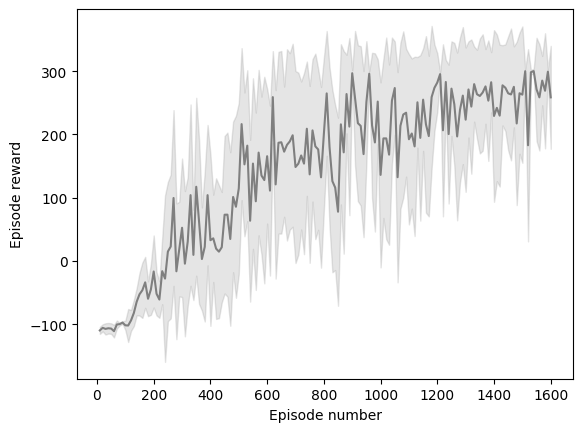

In [11]:
# in the submission please use seed 42 for verification

seed = 42
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

# logging variables
ep_reward = 0
reward_list = []
plot_data = []
log_f = open("./drive/MyDrive/hardcore/agent-log.txt","w+")

# LA3P hyperparameters
gamma = 0.99
tau = 0.005
lr = 3e-4
alpha = 0.2


# experience buffer parametcrs
prioritized_fraction = 0.5
updates = 0
start_steps = 25_000

if not hardcore:
    buffer_size = 1_000_000
else:
    buffer_size = 50_000_000

# general hyperparameters
batch_size = 512
updates_per_step = 1
train_freq = 1
max_episodes = 1_600
max_timesteps = 2_000
total_time_steps = 0






# initialise agent
agent = LA3P_SAC(obs_dim,
                 env.action_space,
                 device,
                 per_alpha = 0.4,
                 min_priority = 1,
                 gamma = gamma,
                 tau = tau,
                 lr = lr,
                 alpha = alpha,
                 target_update_interval = 1,
                 automatic_entropy_tuning = True

                 )


replay_buffer = ActorPrioritizedReplayBuffer(obs_dim, act_dim, max_size=buffer_size, device=device)
# training procedure:
for episode in range(1, max_episodes+1):
    state = env.reset()


    for t in range(max_timesteps):
        if total_time_steps < start_steps:
            action = env.action_space.sample()
        else:
            if use_lstm:
                action = agent.select_action(torch.from_numpy(state), evaluate=False)
            else:
                action = agent.select_action(state, evaluate=False)


        if replay_buffer.size > batch_size and total_time_steps >= start_steps and total_time_steps % train_freq == 0:
            for i in range(updates_per_step):
                agent.update_parameters(replay_buffer, updates, prioritized_fraction, batch_size)
                updates += 1

        next_state, reward, done, info = env.step(action)

        # This reward scaling is ONLY used for the replay buffer, and is NOT logged.
        # In the LA3P paper, they found was found *5 to be optimal for BipedalWalker
        if hardcore:
            augmented_reward = info["aug_reward"] * 5
        else:
            augmented_reward = reward * 5


        total_time_steps += 1
        ep_reward += reward


        if use_lstm:
            replay_buffer.add(torch.from_numpy(state), action, torch.from_numpy(next_state), augmented_reward, done)
        else:
            replay_buffer.add(state, action, next_state, augmented_reward, done)

        state = next_state

        # stop iterating when the episode finished
        if done or t==(max_timesteps-1):
            break

    # append the episode reward to the reward list
    reward_list.append(ep_reward)


    # do NOT change this logging code - it is used for automated marking!
    log_f.write('episode: {}, reward: {}\n'.format(episode, ep_reward))
    log_f.flush()
    ep_reward = 0

    # print reward data every so often - add a graph like this in your report
    if episode % plot_interval == 0:
        plot_data.append([episode, np.array(reward_list).mean(), np.array(reward_list).std()])
        reward_list = []
        # plt.rcParams['figure.dpi'] = 100
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey')
        plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.savefig("./drive/MyDrive/hardcore/reward_graph.png", bbox_inches='tight')
        plt.show()
        disp.clear_output(wait=True)

